In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pylab as plt

# Noise variants

In [3]:
def static_noise(N, mod=1, d=2):
    return mvn.rvs(cov=np.eye(d) * mod, size=N)

def hill_noise(N, low=1, mid=10, top=15):
    """  ____
        /
    ___/
    """
    lower = mvn.rvs(cov=np.eye(2)*low, size=20)
    middle = np.array([mvn.rvs(cov=np.eye(2)*i, size=1) for i in range(mid)])
    upper = mvn.rvs(cov=np.eye(2)*top, size=N-mid-20)
    return np.concatenate([lower, middle, upper])

def sin_noise(N, sin_halves=2):
    a = np.sin([np.pi * (sin_halves*i/N) for i in range(N)])
    return np.array([a,a]).T

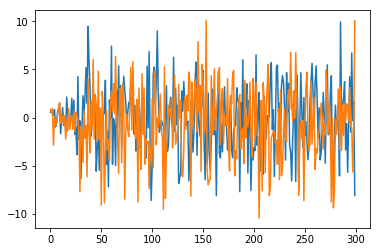

In [4]:
n_hill = hill_noise(300)
plt.plot(n_hill)

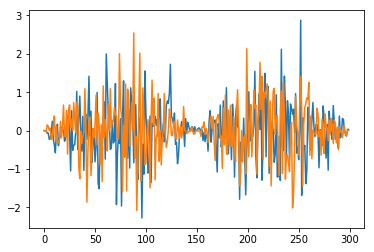

In [5]:
n_sin = static_noise(300) * sin_noise(300)
plt.plot(n_sin)

In [6]:
RMSE_START = 20

In [7]:
from kfsims.common import init_trajectory, init_all
from kfsims.node import node_factory

def daniels_variant(measurements, true, cov, rho=0.95, u=5):
    iterations = 10
    _, xk, P, tau, _, _, _, H, F, Q, N = init_all()
    
    U = cov * (u - 3)
    nd = node_factory(xk, P, u, U, F, Q, H, rho, tau, 
                      observe_factory(measurements.T), iterations)
    nd()
    preds = np.array(nd.logger['x']).squeeze()
    return preds, nd.post_rmse(true.T, start_element=RMSE_START)

from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from kfsims.node import observe_factory

def classic_kf(traj, measurements, true, cov):
    my_filter = KalmanFilter(dim_x=4, dim_z=2)    
    my_filter.x = np.array([[0],[0],[1],[1]])
    my_filter.F = traj.A
    my_filter.H = traj.H
    my_filter.P = 100 * np.eye(4)
    
    my_filter.R = cov
    my_filter.Q = traj.Q
    
    rec = []
    for zk in observe_factory(measurements.T)():
        my_filter.predict()
        my_filter.update(zk)
        x = my_filter.x
        rec.append(x)

    preds = np.array(rec)[:, :, 0]
    return preds, np.mean(np.sqrt((preds[RMSE_START:] - true[RMSE_START:]) ** 2), axis=0)

In [9]:
trj = init_trajectory()
true_traj = trj.X.T
cov_traj = trj.R

# Static noise
## Known exactly
Expected: There should be no difference between CKF and VBKF. R should *not* change

In [10]:
# basically np.eye(2)
np.random.seed(10)
n_static = static_noise(300, mod=4)
cov_init = np.cov(n_static.T) + cov_traj
msrms = trj.Y + n_static.T

In [11]:
res_dv, rms_dv = daniels_variant(msrms, true_traj, cov_init)
rms_dv

array([0.97582782, 0.83959793, 1.04910782, 1.01611218])

In [12]:
res_kfc, rms_kfc = classic_kf(trj, msrms, true_traj, cov_init)
rms_kfc

array([0.9275943 , 0.7821796 , 1.05194614, 0.94859592])

In [13]:
res_dv, rms_dv = daniels_variant(msrms, true_traj, cov_init)
res_kfc, rms_kfc = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv)
print(rms_kfc)

[0.97582782 0.83959793 1.04910782 1.01611218]
[0.9275943  0.7821796  1.05194614 0.94859592]


In [20]:
from utils import plot_single, plot_variants_only, plot_variants

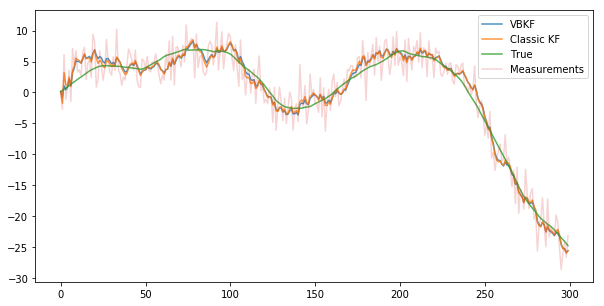

In [21]:
f, ax = plt.subplots(1,1, figsize=(10, 5))
plot_single(ax, 0, res_dv, res_kfc, true_traj, msrms, 0)

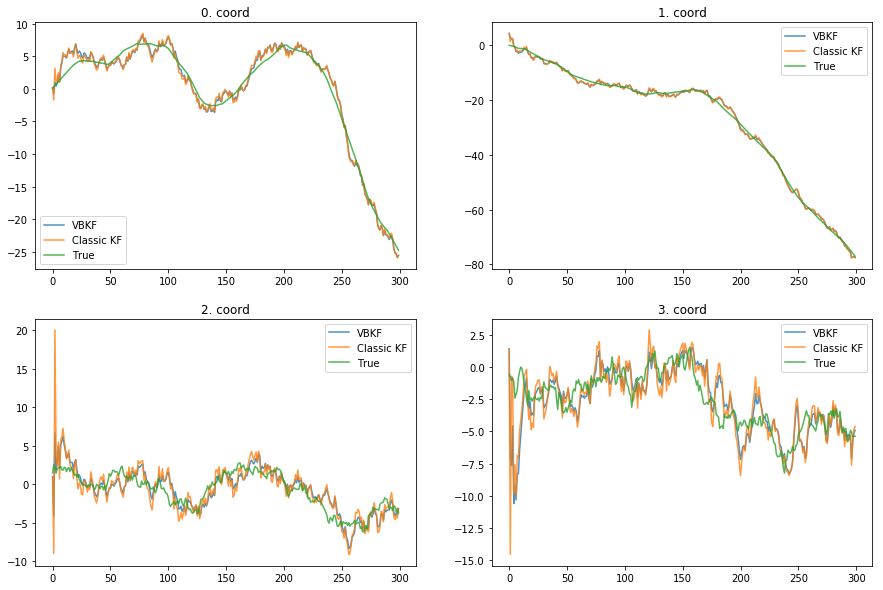

In [22]:
plot_variants_only(res_dv, res_kfc, true_traj, 0)

# Static noise - unknown
Prostě prásknu covariance matrix jako np.eye(2). Bayes se dokáže adaptovat, CKF ne.

In [46]:
# basically np.eye(2)
np.random.seed(10)
n_static = static_noise(300, mod=1)
cov_init = np.eye(2)*0.1 #np.cov(n_static.T) + cov_traj
msrms = trj.Y + n_static.T

res_dv, rms_dv = daniels_variant(msrms, true_traj, cov_init)
res_kfc, rms_kfc = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv)
print(rms_kfc)

[0.86928402 0.78642608 1.06265586 1.01333076]
[1.09105747 1.06812127 2.52683603 2.54727109]


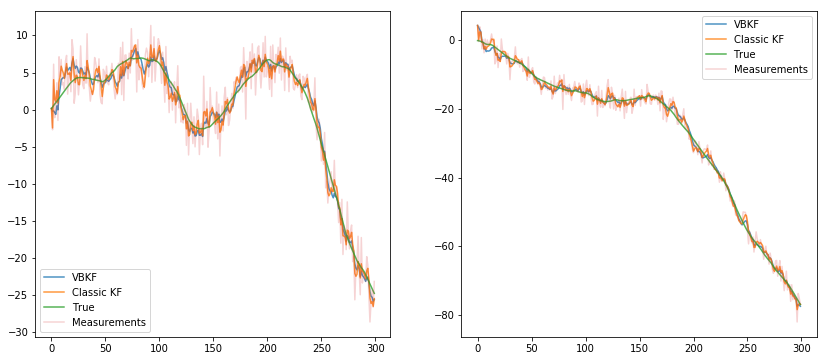

In [47]:
plot_variants(res_dv, res_kfc, msrms, true_traj, 0)

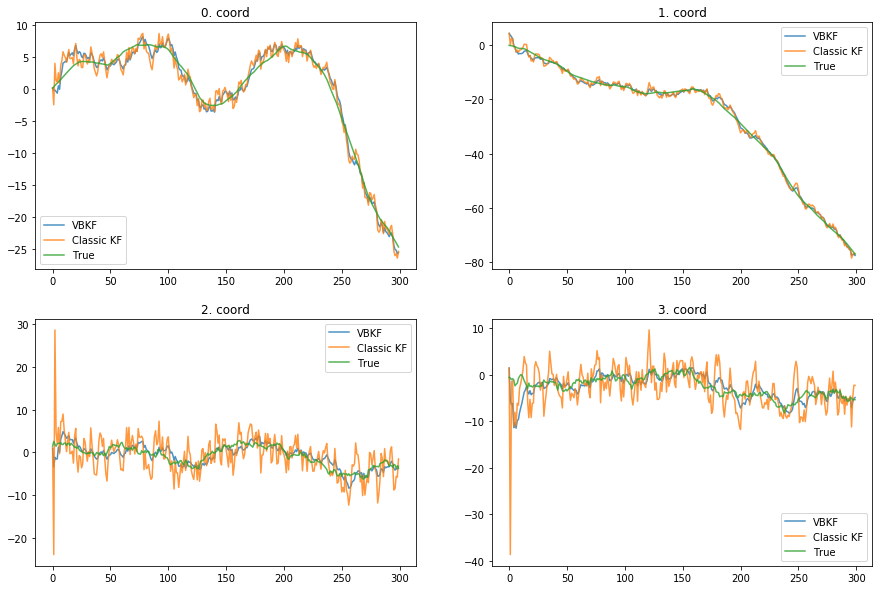

In [48]:
plot_variants_only(res_dv, res_kfc, true_traj, 0)

# Hill noise
## Known
Nastavíme na průměrnou covarianci - tady opět pomáháme CKF, protože průměrnou cov většinou nemáme.

In [26]:
np.random.seed(10)
n_hill = hill_noise(300)
cov_init = np.cov(n_hill.T) + cov_traj
msrms = trj.Y + n_hill.T

res_dv, rms_dv = daniels_variant(msrms, true_traj, cov_init, rho=0.9)
res_kfc, rms_kfc = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv)
print(rms_kfc)

[1.15325228 1.11490432 1.07382304 1.10927219]
[1.13332395 0.98383087 1.10343511 1.02203412]


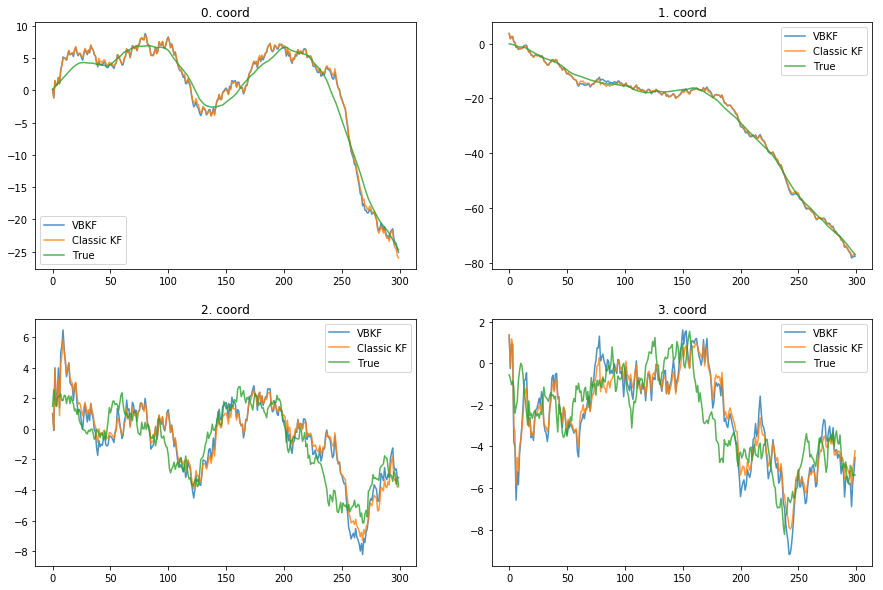

In [27]:
plot_variants_only(res_dv, res_kfc, true_traj, 0)

# Unknown
Bayes by se měl umět přizpůsobit, CKF ne

In [28]:
np.random.seed(10)
n_hill = hill_noise(300)
cov_init = np.eye(2) #np.cov(n_hill.T) #+ cov_traj
msrms = trj.Y + n_hill.T

res_dv, rms_dv = daniels_variant(msrms, true_traj, cov_init, rho=0.9)
res_kfc, rms_kfc = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv)
print(rms_kfc)

[1.15927194 1.11648052 1.07282401 1.11237342]
[1.53487754 1.31940333 1.89096033 1.83347515]


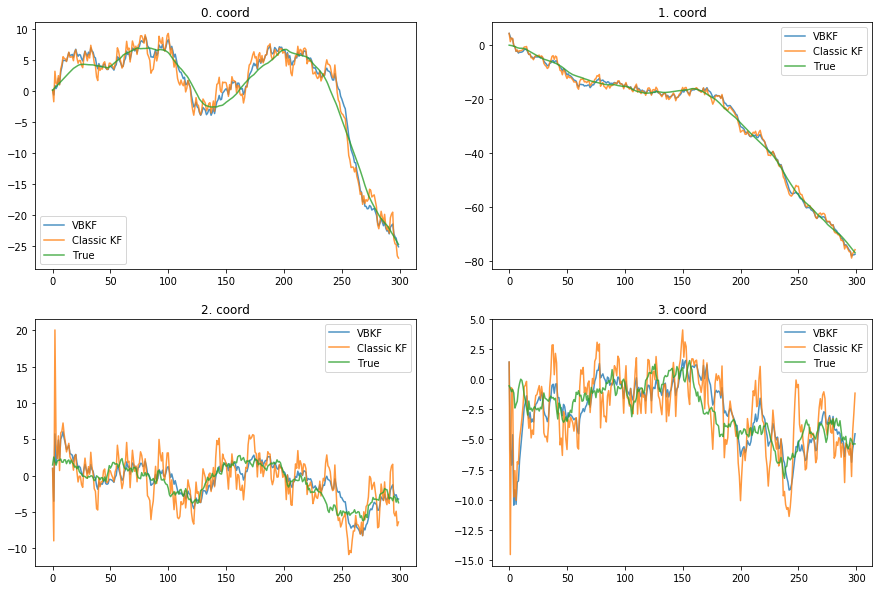

In [29]:
plot_variants_only(res_dv, res_kfc, true_traj, 0)

# Sinus noise
# Known

In [30]:
np.random.seed(10)
n_sin = static_noise(300) * sin_noise(300, 6) * 3
cov_init = np.cov(n_sin.T) + cov_traj
msrms = trj.Y + n_sin.T

res_dv, rms_dv = daniels_variant(msrms, true_traj, cov_init, rho=0.9)
res_kfc, rms_kfc = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv)
print(rms_kfc)

[1.19921649 0.90142957 1.31882421 1.10125689]
[1.15239935 0.86377995 1.31692242 1.04429033]


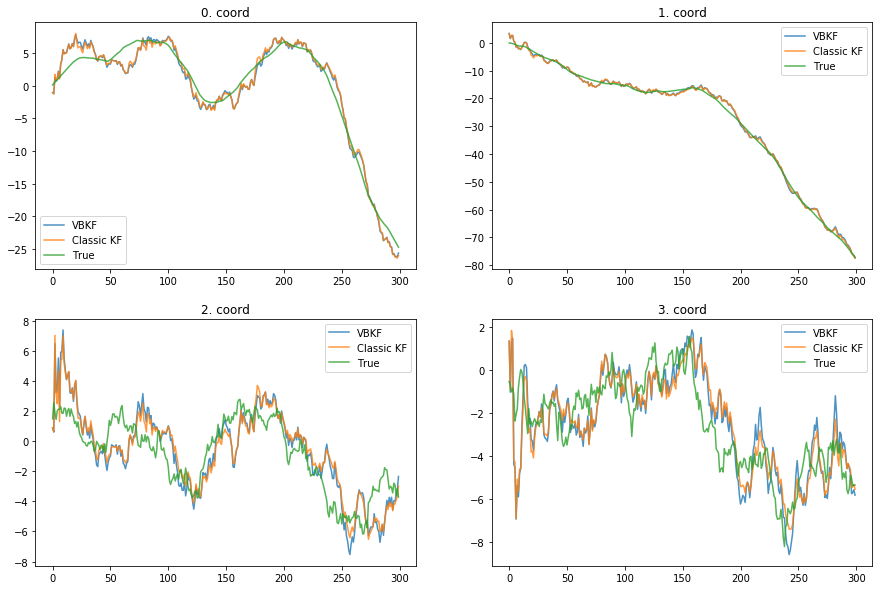

In [31]:
plot_variants_only(res_dv, res_kfc, true_traj, 0)

# Unknown

In [32]:
np.random.seed(10)
n_sin = static_noise(300) * sin_noise(300, 6) * 3
cov_init = np.eye(2) #np.cov(n_sin.T) + cov_traj
msrms = trj.Y + n_sin.T

res_dv, rms_dv = daniels_variant(msrms, true_traj, cov_init, rho=0.9)
res_kfc, rms_kfc = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv)
print(rms_kfc)

[1.22064965 0.90420559 1.33057896 1.10244571]
[1.25890264 1.09364516 1.67103475 1.57020809]


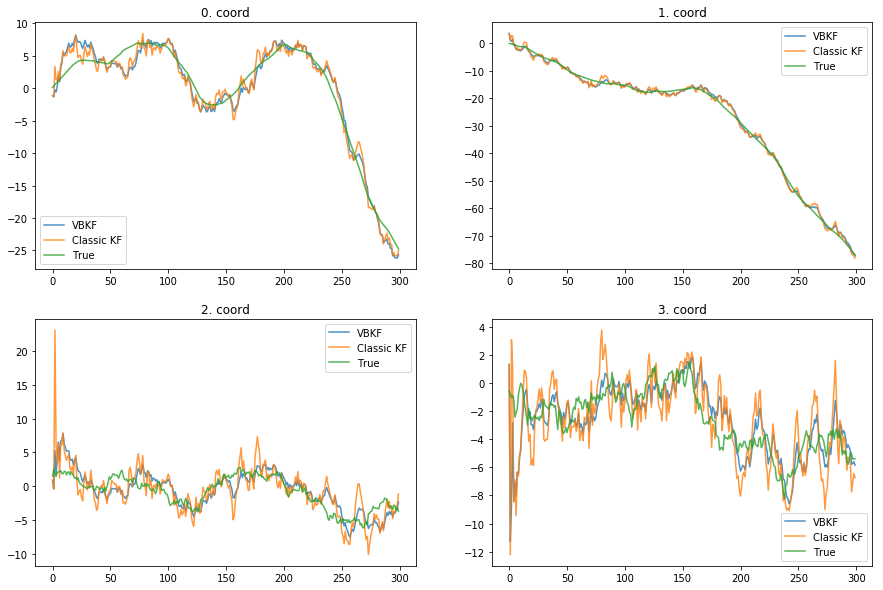

In [33]:
plot_variants_only(res_dv, res_kfc, true_traj, 0)